In [1]:
import numpy as np
import pandas as pd
import os
import json
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras.initializers import RandomUniform
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Activation

import tensorflow
print(tensorflow.__version__)
# from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow import feature_column

from tensorflow.keras import layers
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


2.1.0


Using TensorFlow backend.


<h5> Chapters: 1 -> 7 </h5>

In [2]:
input_path = "gs://agriculture-sara/Test_manual.csv"
input_path = "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 2/All_Manual_Daily_Albedo_NDVI_LST_Cleaned.csv"
df = pd.read_csv(input_path, delimiter=',')
df.head()

# columnsToDrop = ['Date', 'Site Id','Year','Month','Day',
#                  'G','G-1','G-2','G-3','G-4','G-5',
#                  'H', 'H_CORRECTED', 'H_CORRECTED-1', 'H_CORRECTED-2', 'H_CORRECTED-3', 'H_CORRECTED-4',
#                  'H_CORRECTED-5', 'C_BOWENS',
#                  'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
#                  'LE', 'LE_CORRECTED', 'LE_CORRECTED(mm)-1', 'LE_CORRECTED(mm)-2',
#                  'LE_CORRECTED(mm)-3', 'LE_CORRECTED(mm)-4',
#                 'LE_CORRECTED(mm)-5']

columnsToDrop = ['Date','Year','Month','Day', 'Vegetation', 'Latitude', 'Longitude', 'Climate',
                 'G','G-1','G-2','G-3','G-4','G-5',
                 'Climate_1', 'Climate_2', 'Climate_3',
                 'Latitude_1','Latitude_2', 'Latitude_3', 'Latitude_4', 'Latitude_5',
                 'Latitude_6','Longitude_1', 'Longitude_2', 'Longitude_3', 'Longitude_4',
                 'Longitude_5', 'Longitude_6',
                 'H', 'H_bowen_corr', 'H_bowen_corr-1', 'H_bowen_corr-2', 'H_bowen_corr-3', 'H_bowen_corr-4',
                 'H_bowen_corr-5', 'C_BOWENS',
                 'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
                 'LE', 'LE_bowen_corr',
                 'Elevation(m)_1','Elevation(m)_2', 'Elevation(m)_3', 'Elevation(m)_4',
                 'Elevation(m)_5', 'Elevation(m)_6',
                 'ETo', 'EToF', 'ETr', 'ETrF', 'ETo', 'SW_IN']

df = df.drop(columnsToDrop, axis = 1)
df.dropna(inplace=True)

# df.rename(columns={"Site Id_1": "Site_1", "Site Id_2": "Site_2",
#                   "Site Id_3": "Site_3", "Site Id_4": "Site_4",
#                   "Site Id_5": "Site_5"}, inplace=True)

# output_column = "LE_CORRECTED(mm)"
output_column = "LE_bowen_corr(mm)"
df = df[df[output_column].between(1, 15)]
df.head()

Site Id  Site Id_1  Site Id_2  Site Id_3  Site Id_4  Site Id_5  Site Id_6  \
5  FI-Jok          1          0          1          0          1          0   
6  FI-Jok          1          0          1          0          1          0   
7  FI-Jok          1          0          1          0          1          0   
8  FI-Jok          1          0          1          0          1          0   
9  FI-Jok          1          0          1          0          1          0   

   Month_1  Month_2  Month_3  ...  EEflux NDVI-2  EEflux NDVI-3  \
5        0        1        0  ...          0.402          0.413   
6        0        1        0  ...          0.453          0.402   
7        0        1        0  ...          0.481          0.453   
8        0        1        0  ...          0.449          0.481   
9        0        1        0  ...          0.363          0.449   

   EEflux NDVI-4  EEflux NDVI-5  EEflux Albedo  EEflux Albedo-1  \
5          0.316         -0.053          0.122            0.122   
6          0.413          0.316          0.122            0.122   
7          0.402          0.413          0.121            0.122   
8          0.453          0.402          0.121            0.121   
9          0.481          0.453          0.121            0.121   

   EEflux Albedo-2  EEflux Albedo-3  EEflux Albedo-4  EEflux Albedo-5  
5            0.121            0.121            0.110            0.507  
6            0.122            0.121            0.121            0.110  
7            0.122            0.122            0.121            0.121  
8            0.122            0.122            0.122            0.121  
9            0.121            0.122            0.122            0.122  

[5 rows x 51 columns]

In [3]:
def write_dict_to_json(path, content):
    with open(path + '.json', 'w') as file:
        file.write(json.dumps(content, ensure_ascii=False))
    
def write_str_to_txt(path, content):
    text_file = open(path + ".txt", "w")
    text_file.write(content) 
    text_file.close()

def plot_actual_vs_predicted(actual_column, predicted_column):
    plt.plot(list(range(1, len(actual_column) + 1)), actual_column, color='b', label='actual')
    plt.plot(list(range(1, len(actual_column) + 1)), predicted_column, color='r', label='predicted')
    plt.legend(loc='best')
    plt.suptitle('actual vs. predicted')
    plt.savefig(output_path + 'actual_vs_predicted')
    plt.close()
    
def plot_actual_vs_predicted_scatter_bisector(actual_column, predicted_column):
    fig, ax = plt.subplots()
    ax.scatter(actual_column, predicted_column)
    ax.plot([actual_column.min(), actual_column.max()], [predicted_column.min(), predicted_column.max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.suptitle('actual vs. predicted')
    plt.savefig(output_path + 'actual_vs_predicted_scatter_plot')
    plt.close()
    
    
def generate_lags_for(df, column, lags_count): 
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

def generate_lags(df, lagsForColumns):
    '''This function generates the lags for the list of columns'''
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, 5)
    return df

def error_metrics(y_test, y_pred, nb_columns, nb_param):
    n = len(y_test)
    #convert to float for it to work for AIC and BIC data should all be of the same format i.e float not mix of types
    y_test_f =  [float(item) for item in y_test.values]
    y_predict_f =  [float(item) for item in y_pred]
    test_scores = {}
    r2_Score = r2_score(y_test, y_pred)  # r-squared
    adjusted_r2 = 1 - ((1 - r2_Score) * (n - 1)) / (n - nb_columns - 1)  # adjusted r-squared
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    mse_score = mean_squared_error(y_test_f, y_predict_f)  # MSE
    mae_score = mean_absolute_error(y_test, y_pred)  # MAE
    mape_score = np.asarray(np.abs(( np.array(y_test) - np.array(y_pred)) / np.array(y_test)), dtype=np.float64).mean() * 100  # MAPE
    re = (mse_score / np.mean(y_pred)) * 100
    accuracy = 100 - np.mean(mape_score)
    spearman_corr, _ = spearmanr(y_test, y_pred)
    r2 = str(round(r2_Score, 2))
    adjusted_r2 = str(round(adjusted_r2, 2))
    mae = str(round(mae_score, 2))
    mse = str(round(mse_score, 2))
    rmse = str(round(rmse_score, 2))
    re = str(round(re, 2))
    spearman = str(round(spearman_corr, 2))
    mape = str(round(mape_score, 2)) + "%"
    accuracy = str(round(accuracy, 2)) + "%"
    
    nmi = 1
#     normalized_mutual_info_score(y_test_n, y_pred)
    
#     nmi = 0
#     inm = drv.information_mutual_normalised(y_test, y_pred)
#     array_sum = np.sum(inm)
#     inm_has_nan = np.isnan(array_sum)
#     if inm_has_nan:
#         nmi = "NaN"
#     else:
#         nmi = str(inm)


    def calculate_aic(n, mse, num_params):
        aic = n * log(mse) + 2 * num_params
        return aic

    def calculate_bic(n, mse, num_params):
        bic = n * log(mse) + num_params * log(n)
        return bic

    aic = str(round(calculate_aic(len(y_test), mse_score, nb_param), 2))
    bic = str(round(calculate_bic(len(y_test), mse_score, nb_param), 2))

    test_scores["average output"] =  str(y_test.mean())
    test_scores["R2"] = r2
    test_scores["Adjusted R2"] = adjusted_r2
    test_scores["MAE"] = mae
    test_scores["MSE"] = mse
    test_scores["RMSE"] = rmse
    test_scores["Relative Error"] = re
    test_scores["Spearman"] = spearman
    test_scores["MAPE"] = mape
    test_scores["Accuracy"] = accuracy
    test_scores["Information Mutal Normalised"] = nmi
    test_scores["AIC"] = aic
    test_scores["BIC"] = bic
    return test_scores

def binary_encode_column(df, columnToEncode):
    encoder = ce.BinaryEncoder(cols=[columnToEncode])
    df_encoder = encoder.fit_transform(df[columnToEncode])
    df = pd.concat([df, df_encoder], axis=1)
    return df

In [4]:
lagsForColumns = ["SW_IN", "WS", "RH", "TA", "EEflux LST", "EEflux Albedo", "EEflux NDVI"]
df = generate_lags(df, lagsForColumns)
print(df.columns)
print(df.shape)

num_features = df.shape[1]
print(num_features)

df.isnull().mean() * 10
df.dropna(inplace=True)
print(df.shape)

TRAIN_RATIO = 0.6
TEST_RATIO = 0.2

def split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    X_valid = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    Y_valid = pd.DataFrame()
    unique_sites = df["Site Id"].unique()
    print("Number of sites:", len(unique_sites))
    for site in unique_sites:
        df_site = df[df["Site Id"] == site]
#         X = df_site.drop([output_column], axis = 1)
#         Y = df_site[output_column]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))
        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:test_index], ignore_index = True)
        X_valid = X_valid.append(X[test_index:], ignore_index = True)
        
        Y_train = Y_train.append(X[:train_index], ignore_index = False)
        Y_test = Y_test.append(X[train_index:test_index], ignore_index = False)
        Y_valid = Y_valid.append(X[test_index:], ignore_index = False)
    
    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
    Y_valid = Y_valid[[output_column]]
    
    X_train = X_train.drop([output_column], axis = 1) 
    X_test = X_test.drop([output_column], axis = 1) 
    X_valid = X_valid.drop([output_column], axis = 1) 
    
    return (X_train, Y_train, X_test, Y_test, X_valid, Y_valid)
    
X_train, Y_train, X_test, Y_test, X_valid, Y_valid = split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape, "X_valid shape:", X_valid.shape)
print("Y_train shape:", Y_train.shape, "Y_test shape:", Y_test.shape, "Y_valid shape:", Y_valid.shape)

columnToDrop = "Site Id"
X_train.drop([columnToDrop], axis = 1, inplace=True)
X_test.drop([columnToDrop], axis = 1, inplace=True)
X_valid.drop([columnToDrop], axis = 1, inplace=True)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

n_input = X_train.shape[1]
n_classes = 1
print("num of input:", n_input, "num of classes:", n_classes)

nb_columns = len(list(df.columns.values)) - 1

Index(['Site Id', 'Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4',
       'Site Id_5', 'Site Id_6', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Vegetation_1', 'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2',
       'WS-3', 'WS-4', 'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5',
       'TA', 'TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr(mm)',
       'EEflux LST', 'EEflux LST-1', 'EEflux LST-2', 'EEflux LST-3',
       'EEflux LST-4', 'EEflux LST-5', 'EEflux NDVI', 'EEflux NDVI-1',
       'EEflux NDVI-2', 'EEflux NDVI-3', 'EEflux NDVI-4', 'EEflux NDVI-5',
       'EEflux Albedo', 'EEflux Albedo-1', 'EEflux Albedo-2',
       'EEflux Albedo-3', 'EEflux Albedo-4', 'EEflux Albedo-5'],
      dtype='object')
(10916, 51)
51
(10911, 51)
Number of sites: 26
X_train shape: (6536, 50) X_test shape: (2182, 50) X_valid shape: (2193, 50)
Y_train shape: (6536, 1) Y_test shape: (2182, 1) Y_valid shape: (2193, 1)
num of input: 49 num of classes: 1


In [5]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

root_logdir = os.path.join(os.curdir, "my_logs")
logdir = os.path.join(root_logdir, "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

# %load_ext tensorboard

# %tensorboard --logdir=./my_logs

def error_metrics(y_test, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    n = len(y_test)

    r2_Score = r2_score(y_test, y_pred)  # r-squared
    adjusted_r2 = 1 - ((1 - r2_Score) * (n - 1)) / (n - nb_columns - 1)  # adjusted r-squared
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    mse_score = mean_squared_error(y_test, y_pred)  # MSE
    mae_score = mean_absolute_error(y_test, y_pred)  # MAE
    mape_score = np.asarray(np.abs(( np.array(y_test) - np.array(y_pred)) / np.array(y_test)), dtype=np.float64).mean() * 100  # MAPE
    re = (mse_score / np.mean(y_pred)) * 100
    print("Average target is:", Y_train.mean())
    print("The range for the output variable is: " + str(y_test.mean()))
    print("r2score : " + str(r2_Score))
    print("adjusted r2score : " + str(adjusted_r2))
    print("mae : " + str(mae_score))
    print("rmse : " + str(rmse_score))
    print("mse : " + str(mse_score))
    print("re : " + str(re))
    print("mape : " + str(mape_score))
    
nb_columns = len(list(df.columns.values)) - 1

<h3> Chapter 2: Configure Capacity with Nodes and Layers </h3>

In [ ]:
# # fit model with given number of layers, returns test set accuracy
# def evaluate_model(n_layers, trainX, trainy, testX, testy, validX, validY): # configure the model based on the data
#     # define model
#     model = Sequential()
#     model.add(Dense(50, input_dim=trainX.shape[1], activation='relu',kernel_initializer='he_uniform'))
#     for _ in range(1, n_layers):
#         model.add(Dense(1, activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dense(n_classes, activation='softmax'))
#     # compile model
#     opt = SGD(lr=0.01, momentum=0.9)
#     model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])
#     # fit model
#     history = model.fit(trainX, trainy, validation_data=(validX, validY),
#                         epochs=300, batch_size=64, verbose=1, callbacks=callbacks)
#     return (history, model)

def evaluate_model(n_layers,
                first_neuron=64,
                 activation='softmax',
                 init='uniform',
                 dropout_rate = 0.4,
                 optimizer='Adam',
                 loss='mse'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=X_train_scaled.shape[1], kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    for _ in range(1, n_layers):
        model.add(Dense(1, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    output_path = "Daily Experiments/Base/Manual All/Model_" + str(n_layers)
    mc = ModelCheckpoint(output_path, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
    history = model.fit(X_train_scaled, Y_train, validation_data=(X_valid_scaled, Y_valid),callbacks=[es, mc], epochs=200, batch_size=64, verbose=0)
    return (history, model)


Epoch 00001: val_mape improved from inf to 42.78728, saving model to Daily Experiments/Base/Manual All/Model_1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_1/assets

Epoch 00002: val_mape did not improve from 42.78728

Epoch 00003: val_mape did not improve from 42.78728

Epoch 00004: val_mape did not improve from 42.78728

Epoch 00005: val_mape did not improve from 42.78728

Epoch 00006: val_mape improved from 42.78728 to 42.11754, saving model to Daily Experiments/Base/Manual All/Model_1
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_1/assets

Epoch 00007: val_mape improved from 42.11754 to 37.26898, saving model to Daily Experiments/Base/Manual All/Model_1
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_1/assets

Epoch 00008: val_mape improved from 37.26898 to 34.70918, saving model to Daily Experiments/Base/Manual All/

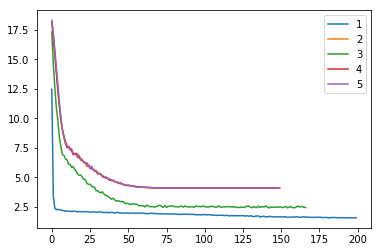

In [14]:
# evaluate model and plot learning curve of model with given number of layers
all_history = list()
num_layers = [1, 2, 3, 4, 5]
for n_layers in num_layers:
  # evaluate model with a given number of layers
    history, model = evaluate_model(n_layers)
    
    loss, train_mse, train_mae, train_acc, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=2)
    loss, val_mse, val_mae, val_acc, val_mape = model.evaluate(X_valid_scaled, Y_valid, verbose=2)
    loss, test_mse, test_mae, test_acc, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=2)

    print("train mse:", train_mse, "validation mse:", val_mse, "test mse:", test_mse)
    print("train mae:", train_mae, "validation mae:", val_mae, "test mae:", test_mae)
    print("train mape:", train_mape, "validation mape:", val_mape, "test mape:", test_mape)

    print('layers=%d: MSE %.3f' % (n_layers, test_mse))
    
    Y_predict = model.predict(X_test_scaled)
    error_metrics(Y_test, Y_predict)
    # plot learning curve
    plt.plot(history.history['loss'], label=str(n_layers))

plt.legend()
plt.show()

<h3> Chapter 3: Configure Gradient Precision with Batch Size </h3>

<ul>
    <li>Batch Gradient Descent: Batch size is set to the total number of examples in the training dataset. It uses a relatively larger learning rate and more training epochs. </li>
    <li>Stochastic Gradient Descent: Batch size is set to one. It uses a relatively smaller learning rate and fewer training epochs.
</li>
    <li>Minibatch Gradient Descent: Batch size is set to more than one and less than the
        total number of examples in the training dataset</li>
 </ul>

Batch size: good default is 32 or 64

In [9]:
# fit a model and plot learning curve
# def fit_model(trainX, trainy, testX, testy, validX, validy, n_batch):
#     # define model
#     model = Sequential()
#     model.add(Dense(50, input_dim=trainX.shape[1], activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dense(1, activation='softmax'))
#       # compile model
#     opt = SGD(lr=0.01, momentum=0.9)
#     model.compile(loss='mse', optimizer=opt, metrics=['accuracy', 'mse', 'mae'])
#     # fit model
#     history = model.fit(trainX, trainy, validation_data=(validX, validy), epochs=300, verbose=1,
#                         batch_size=n_batch, callbacks=callbacks)
    
#     return history, model

def fit_model(n_batch, first_neuron=50, 
              activation='relu',
                 init='uniform',
                 dropout_rate = 0.0,
                 optimizer='Adam',
                 loss='mse'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=X_train_scaled.shape[1], kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    for _ in range(1, 3):
        model.add(Dense(1, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    output_path = "Daily Experiments/Base/Manual All/Model_Batch_" + str(n_batch)
    mc = ModelCheckpoint(output_path, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
    history = model.fit(X_train_scaled, Y_train, validation_data=(X_valid_scaled, Y_valid),callbacks=[es, mc], epochs=300, batch_size=n_batch, verbose=1)
    return (history, model)

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6496/6536 [============================>.] - ETA: 0s - loss: 17.2039 - mse: 17.2038 - mae: 3.6162 - accuracy: 0.0000e+00 - mape: 92.4783
Epoch 00001: val_mape improved from inf to 82.98190, saving model to Daily Experiments/Base/Manual All/Model_Batch_32
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Batch_32/assets
6536/6536 [==============================] - 4s 598us/sample - loss: 17.1781 - mse: 17.1780 - mae: 3.6130 - accuracy: 0.0000e+00 - mape: 92.4173 - val_loss: 13.3550 - val_mse: 13.3550 - val_mae: 3.1214 - val_accuracy: 0.0000e+00 - val_mape: 82.9819
Epoch 2/300
6528/6536 [============================>.] - ETA: 0s - loss: 13.7069 - mse: 13.7069 - mae: 3.0961 - accuracy: 0.0000e+00 - mape: 74.1291
Epoch 00002: val_mape improved from 82.98190 to 61.07527, saving model to Daily Experiments/Base/Manual All/Model_B

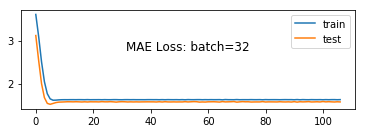

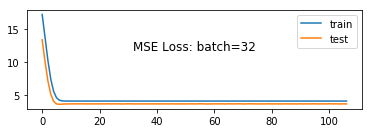

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6400/6536 [============================>.] - ETA: 0s - loss: 17.8947 - mse: 17.8933 - mae: 3.7132 - accuracy: 0.0000e+00 - mape: 96.1360
Epoch 00001: val_mape improved from inf to 91.40465, saving model to Daily Experiments/Base/Manual All/Model_Batch_64
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Batch_64/assets
6536/6536 [==============================] - 3s 401us/sample - loss: 17.9270 - mse: 17.9256 - mae: 3.7159 - accuracy: 0.0000e+00 - mape: 96.0592 - val_loss: 14.8044 - val_mse: 14.8031 - val_mae: 3.3453 - val_accuracy: 0.0000e+00 - val_mape: 91.4046
Epoch 2/300
6144/6536 [===========================>..] - ETA: 0s - loss: 16.2918 - mse: 16.2906 - mae: 3.4873 - accuracy: 0.0000e+00 - mape: 87.7383
Epoch 00002: val_mape improved from 91.40465 to 81.55628, saving model to Daily Experiments/Base/Manual All/Model_Batch_64
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Mode

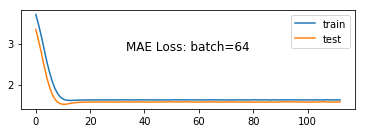

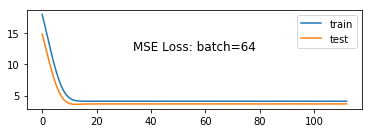

Train on 6536 samples, validate on 2193 samples
Epoch 1/300

Epoch 00001: val_mape improved from inf to 99.91417, saving model to Daily Experiments/Base/Manual All/Model_Batch_6536
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Batch_6536/assets
6536/6536 [==============================] - 2s 296us/sample - loss: 18.7585 - mse: 18.7565 - mae: 3.8261 - accuracy: 0.0000e+00 - mape: 101.1393 - val_loss: 16.3698 - val_mse: 16.3678 - val_mae: 3.5716 - val_accuracy: 0.0000e+00 - val_mape: 99.9142
Epoch 2/300

Epoch 00002: val_mape improved from 99.91417 to 99.82710, saving model to Daily Experiments/Base/Manual All/Model_Batch_6536
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Batch_6536/assets
6536/6536 [==============================] - 1s 174us/sample - loss: 18.7222 - mse: 18.7201 - mae: 3.8238 - accuracy: 0.0000e+00 - mape: 99.9531 - val_loss: 16.3535 - val_mse: 16.3515 - val_mae: 3.5693 - val_accuracy: 0.0000e+00 - val_mape: 99.8

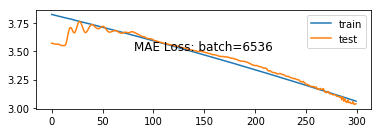

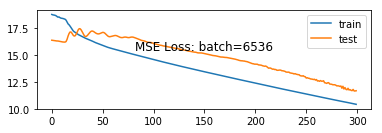

In [10]:
# create learning curves for different batch sizes
batch_sizes = [32, 64, X_train_scaled.shape[0]]
for i in range(len(batch_sizes)):
  # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    # fit model and plot learning curves for a batch size
    history, model = fit_model(batch_sizes[i])
    
    # evaluate the model
    loss, train_mse, train_mae, train_acc, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=2)
    loss, val_mse, val_mae, val_acc, val_mape = model.evaluate(X_valid_scaled, Y_valid, verbose=2)
    loss, test_mse, test_mae, test_acc, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=2)

    print("train mse:", train_mse, "validation mse:", val_mse, "test mse:", test_mse)
    print("train mae:", train_mae, "validation mae:", val_mae, "test mae:", test_mae)
    print("train mape:", train_mape, "validation mape:", val_mape, "test mape:", test_mape)

    print("Train:", train_mse, "Test:", test_mse)
#     print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

    Y_predict = model.predict(X_test_scaled)
    error_metrics(Y_test, Y_predict)

    # show learning curves 
    plt.subplot(211)
    plt.title('MAE Loss: batch='+str(batch_sizes[i]), pad=-40)
    plt.plot(history.history['mae'], label='train')
    plt.plot(history.history['val_mae'], label='test')
    plt.legend()
    plt.show()
    # plot mse during training
    plt.subplot(212)
    plt.title('MSE Loss: batch='+str(batch_sizes[i]), pad=-40)
    plt.plot(history.history['mse'], label='train')
    plt.plot(history.history['val_mse'], label='test')
    plt.legend()
    plt.show()


<h3> Chapter 4: Configure What to Optimize with Loss Functions </h4>

Loss: MSE

In [17]:
def fit_model(first_neuron=64, 
              activation='softmax',
                 init='uniform',
                 dropout_rate = 0.4,
                 optimizer='Adam',
                 loss='mse'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=X_train_scaled.shape[1], kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    for _ in range(1, 3):
        model.add(Dense(1, activation='relu', kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    output_path = "Daily Experiments/Base/Manual All/Model_Loss_" + str(loss)
    mc = ModelCheckpoint(output_path, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
    history = model.fit(X_train_scaled, Y_train, validation_data=(X_valid_scaled, Y_valid),callbacks=[es, mc], epochs=300, batch_size=64, verbose=1)
    return (history, model)

history, model = fit_model(loss='mean_squared_error')

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6400/6536 [============================>.] - ETA: 0s - loss: 17.7745 - mse: 17.7742 - mae: 3.6954 - accuracy: 0.0000e+00 - mape: 95.3972
Epoch 00001: val_mape improved from inf to 89.67252, saving model to Daily Experiments/Base/Manual All/Model_Loss_mean_squared_error
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Loss_mean_squared_error/assets
6536/6536 [==============================] - 3s 394us/sample - loss: 17.7697 - mse: 17.7693 - mae: 3.6945 - accuracy: 0.0000e+00 - mape: 95.3078 - val_loss: 14.4971 - val_mse: 14.4971 - val_mae: 3.2993 - val_accuracy: 0.0000e+00 - val_mape: 89.6725
Epoch 2/300
6400/6536 [============================>.] - ETA: 0s - loss: 15.7928 - mse: 15.7928 - mae: 3.4090 - accuracy: 0.0000e+00 - mape: 84.9894
Epoch 00002: val_mape improved from 89.67252 to 78.28755, saving model to Daily Experiments/Base/Manual All/Model_Loss_mean_squared_error
INFO:tensorflow:Assets writt

6536/6536 - 1s - loss: 4.1023 - mse: 4.1023 - mae: 1.6260 - accuracy: 0.0000e+00 - mape: 60.9950
2193/2193 - 0s - loss: 3.6754 - mse: 3.6754 - mae: 1.5754 - accuracy: 0.0000e+00 - mape: 65.0013
2182/2182 - 0s - loss: 3.9521 - mse: 3.9521 - mae: 1.6150 - accuracy: 0.0000e+00 - mape: 63.0117
train mse: 4.102268 validation mse: 3.6754165 test mse: 3.9521112
train mae: 1.6259936 validation mae: 1.5753502 test mae: 1.614976
train mape: 60.995018 validation mape: 65.001274 test mape: 63.011673
Train: 4.102, Test: 3.952
Average target is: LE_bowen_corr(mm)    3.826096
dtype: float64
The range for the output variable is: LE_bowen_corr(mm)    3.684851
dtype: float64
r2score : -0.00507923060428106
adjusted r2score : -0.028661568253372627
mae : 1.6149766136078214
rmse : 1.9879917643891059
mse : 3.9521112552789104
re : 103.29146645782843
mape : 63.01166183619122


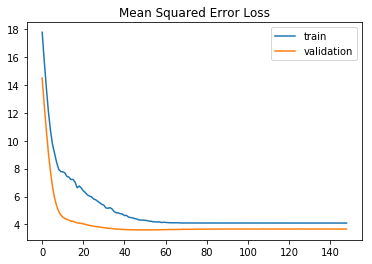

In [18]:
# evaluate the model
loss, train_mse, train_mae, train_acc, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=2)
loss, val_mse, val_mae, val_acc, val_mape = model.evaluate(X_valid_scaled, Y_valid, verbose=2)
loss, test_mse, test_mae, test_acc, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=2)

print("train mse:", train_mse, "validation mse:", val_mse, "test mse:", test_mse)
print("train mae:", train_mae, "validation mae:", val_mae, "test mae:", test_mae)
print("train mape:", train_mape, "validation mape:", val_mape, "test mape:", test_mape)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Y_predict = model.predict(X_test_scaled)
error_metrics(Y_test, Y_predict)

plt.title('Mean Squared Error Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Loss: Logarithmic

In [19]:
history, model = fit_model(loss='mean_squared_logarithmic_error')

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6144/6536 [===========================>..] - ETA: 0s - loss: 2.3917 - mse: 18.8382 - mae: 3.8318 - accuracy: 0.0000e+00 - mape: 100.0000
Epoch 00001: val_mape improved from inf to 100.00000, saving model to Daily Experiments/Base/Manual All/Model_Loss_mean_squared_logarithmic_error
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Loss_mean_squared_logarithmic_error/assets
6536/6536 [==============================] - 3s 411us/sample - loss: 2.3890 - mse: 18.7413 - mae: 3.8261 - accuracy: 0.0000e+00 - mape: 100.0000 - val_loss: 2.2324 - val_mse: 16.3843 - val_mae: 3.5739 - val_accuracy: 0.0000e+00 - val_mape: 100.0000
Epoch 2/300
6272/6536 [===========================>..] - ETA: 0s - loss: 2.3825 - mse: 18.6605 - mae: 3.8164 - accuracy: 0.0000e+00 - mape: 100.0000
Epoch 00002: val_mape did not improve from 100.00000
6536/6536 [==============================] - 1s 96us/sample - loss: 2.3886 - mse: 18.741

6536/6536 - 1s - loss: 2.3886 - mse: 18.7413 - mae: 3.8261 - accuracy: 0.0000e+00 - mape: 100.0000
2193/2193 - 0s - loss: 2.2324 - mse: 16.3843 - mae: 3.5739 - accuracy: 0.0000e+00 - mape: 100.0000
2182/2182 - 0s - loss: 2.2990 - mse: 17.5103 - mae: 3.6849 - accuracy: 0.0000e+00 - mape: 100.0000
train mse: 18.741274 validation mse: 16.38432 test mse: 17.510267
train mae: 3.8260949 validation mae: 3.5738716 test mae: 3.6848512
train mape: 100.0 validation mape: 100.0 test mape: 100.0
Train: 18.741, Test: 17.510
Average target is: LE_bowen_corr(mm)    3.826096
dtype: float64
The range for the output variable is: LE_bowen_corr(mm)    3.684851
dtype: float64
r2score : -3.45311436822663
adjusted r2score : -3.5575985157683148
mae : 3.684850842121548
rmse : 4.184526824282559
mse : 17.510264743140276
re : inf
mape : 100.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


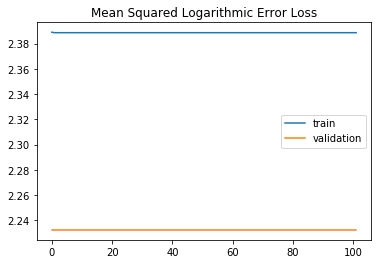

In [21]:
# evaluate the model
loss, train_mse, train_mae, train_acc, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=2)
loss, val_mse, val_mae, val_acc, val_mape = model.evaluate(X_valid_scaled, Y_valid, verbose=2)
loss, test_mse, test_mae, test_acc, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=2)

print("train mse:", train_mse, "validation mse:", val_mse, "test mse:", test_mse)
print("train mae:", train_mae, "validation mae:", val_mae, "test mae:", test_mae)
print("train mape:", train_mape, "validation mape:", val_mape, "test mape:", test_mape)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Y_predict = model.predict(X_test_scaled)
error_metrics(Y_test, Y_predict)
# plot loss during training
plt.title('Mean Squared Logarithmic Error Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Loss: MAE

In [22]:
history, model = fit_model(loss='mean_absolute_error')

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6336/6536 [============================>.] - ETA: 0s - loss: 3.7309 - mse: 18.0249 - mae: 3.7306 - accuracy: 0.0000e+00 - mape: 96.7234
Epoch 00001: val_mape improved from inf to 92.49602, saving model to Daily Experiments/Base/Manual All/Model_Loss_mean_absolute_error
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Loss_mean_absolute_error/assets
6536/6536 [==============================] - 3s 396us/sample - loss: 3.7317 - mse: 18.0341 - mae: 3.7313 - accuracy: 0.0000e+00 - mape: 96.6122 - val_loss: 3.3744 - val_mse: 14.9981 - val_mae: 3.3744 - val_accuracy: 0.0000e+00 - val_mape: 92.4960
Epoch 2/300
6144/6536 [===========================>..] - ETA: 0s - loss: 3.5261 - mse: 16.5774 - mae: 3.5261 - accuracy: 0.0000e+00 - mape: 89.0863
Epoch 00002: val_mape improved from 92.49602 to 83.33283, saving model to Daily Experiments/Base/Manual All/Model_Loss_mean_absolute_error
INFO:tensorflow:Assets writte

6536/6536 - 1s - loss: 1.6126 - mse: 4.1646 - mae: 1.6126 - accuracy: 0.0000e+00 - mape: 56.6688
2193/2193 - 0s - loss: 1.5355 - mse: 3.6118 - mae: 1.5355 - accuracy: 0.0000e+00 - mape: 59.7225
2182/2182 - 0s - loss: 1.5789 - mse: 3.9439 - mae: 1.5789 - accuracy: 0.0000e+00 - mape: 57.9622
train mse: 4.164634 validation mse: 3.6117654 test mse: 3.943909
train mae: 1.6125908 validation mae: 1.5354838 test mae: 1.5789287
train mape: 56.66881 validation mape: 59.722534 test mape: 57.96217
Train: 4.165, Test: 3.944
Average target is: LE_bowen_corr(mm)    3.826096
dtype: float64
The range for the output variable is: LE_bowen_corr(mm)    3.684851
dtype: float64
r2score : -0.0029932309000064716
adjusted r2score : -0.026526624398364174
mae : 1.5789285744211432
rmse : 1.9859276961807013
mse : 3.943908814457588
re : 110.27711030819094
mape : 57.96215577742948


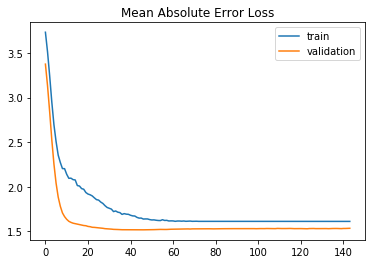

In [23]:
# evaluate the model
loss, train_mse, train_mae, train_acc, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=2)
loss, val_mse, val_mae, val_acc, val_mape = model.evaluate(X_valid_scaled, Y_valid, verbose=2)
loss, test_mse, test_mae, test_acc, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=2)

print("train mse:", train_mse, "validation mse:", val_mse, "test mse:", test_mse)
print("train mae:", train_mae, "validation mae:", val_mae, "test mae:", test_mae)
print("train mape:", train_mape, "validation mape:", val_mape, "test mape:", test_mape)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Y_predict = model.predict(X_test_scaled)
error_metrics(Y_test, Y_predict)
# plot loss during training

plt.title('Mean Absolute Error Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [24]:
history, model = fit_model(loss='mean_absolute_percentage_error')

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6400/6536 [============================>.] - ETA: 0s - loss: 96.3633 - mse: 17.9638 - mae: 3.7208 - accuracy: 0.0000e+00 - mape: 96.3629
Epoch 00001: val_mape improved from inf to 91.64624, saving model to Daily Experiments/Base/Manual All/Model_Loss_mean_absolute_percentage_error
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Loss_mean_absolute_percentage_error/assets
6536/6536 [==============================] - 3s 402us/sample - loss: 96.2950 - mse: 17.9576 - mae: 3.7214 - accuracy: 0.0000e+00 - mape: 96.2946 - val_loss: 91.6462 - val_mse: 14.8461 - val_mae: 3.3518 - val_accuracy: 0.0000e+00 - val_mape: 91.6462
Epoch 2/300
6400/6536 [============================>.] - ETA: 0s - loss: 87.6973 - mse: 16.2368 - mae: 3.4800 - accuracy: 0.0000e+00 - mape: 87.6973
Epoch 00002: val_mape improved from 91.64624 to 81.61691, saving model to Daily Experiments/Base/Manual All/Model_Loss_mean_absolute_percentag

6536/6536 - 1s - loss: 45.5324 - mse: 6.3529 - mae: 1.8814 - accuracy: 0.0000e+00 - mape: 45.5324
2193/2193 - 0s - loss: 44.0338 - mse: 5.1693 - mae: 1.6799 - accuracy: 0.0000e+00 - mape: 44.0338
2182/2182 - 0s - loss: 44.0574 - mse: 5.7790 - mae: 1.7620 - accuracy: 0.0000e+00 - mape: 44.0574
train mse: 6.35294 validation mse: 5.1692643 test mse: 5.7789655
train mae: 1.8814338 validation mae: 1.6798836 test mae: 1.7619613
train mape: 45.532417 validation mape: 44.033836 test mape: 44.05739
Train: 6.353, Test: 5.779
Average target is: LE_bowen_corr(mm)    3.826096
dtype: float64
The range for the output variable is: LE_bowen_corr(mm)    3.684851
dtype: float64
r2score : -0.4696747062185249
adjusted r2score : -0.5041579231640558
mae : 1.7619614526245964
rmse : 2.403947846955421
mse : 5.778965250881604
re : 248.46459095291357
mape : 44.05738326979309


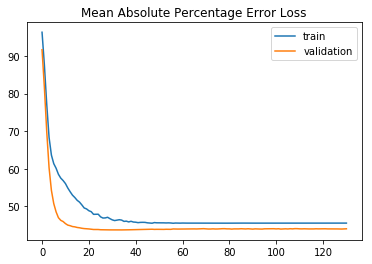

In [25]:
# evaluate the model
loss, train_mse, train_mae, train_acc, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=2)
loss, val_mse, val_mae, val_acc, val_mape = model.evaluate(X_valid_scaled, Y_valid, verbose=2)
loss, test_mse, test_mae, test_acc, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=2)

print("train mse:", train_mse, "validation mse:", val_mse, "test mse:", test_mse)
print("train mae:", train_mae, "validation mae:", val_mae, "test mae:", test_mae)
print("train mape:", train_mape, "validation mape:", val_mape, "test mape:", test_mape)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Y_predict = model.predict(X_test_scaled)
error_metrics(Y_test, Y_predict)
# plot loss during training

plt.title('Mean Absolute Percentage Error Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

<h5>Observation: We notice that the MSE generalizes better for a new unseen data with respect
to the other metrics the logarithmic and MAE</h5>

<h3> Chapter 5: Configure Speed of Learning with Learning Rate </h3>

<ol>
<li> Vary Learning Rate: </li>
<li> Vary Momentum: </li>
</ol>

<h4> Vary Learning Rate </h4>

In [34]:
# # fit a model and plot learning curve
# def fit_model(trainX, trainy, validX, validy, lrate):
#     # define model
#     model = Sequential()
#     model.add(Dense(50, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dense(1, activation='softmax'))
#       # compile model
#     opt = SGD(lr=lrate)
#     model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mse', 'mae'])
#     # fit model
#     history = model.fit(trainX, trainy, validation_data=(validX, validy), epochs=300, verbose=1, callbacks=callbacks)

    
def fit_model(lrate, first_neuron=64, 
              activation='softmax',
                 init='uniform',
                 dropout_rate = 0.4,
                 optimizer='Adam',
                 loss='mse'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=X_train_scaled.shape[1], kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for _ in range(1, 3):
        model.add(Dense(first_neuron, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    opt = tensorflow.keras.optimizers.SGD(lr=lrate)
    model.compile(optimizer=opt, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    output_path = "Daily Experiments/Base/Manual All/Model_Loss_" + str(loss)
    mc = ModelCheckpoint(output_path, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
    history = model.fit(X_train_scaled, Y_train, validation_data=(X_valid_scaled, Y_valid),callbacks=[es, mc], epochs=300, batch_size=64, verbose=1)
    return (history, model)

Average target is: LE_bowen_corr(mm)    3.826096
dtype: float64
The range for the output variable is: LE_bowen_corr(mm)    3.684851
dtype: float64
r2score : 0.6108656367343137
adjusted r2score : 0.6017353138045698
mae : 0.9204527611808137
rmse : 1.2369844023522094
mse : 1.5301304116626528
re : 39.73993689592577
mape : 32.713101969288374


Text(0.5, 1.0, 'lrate=1.0')

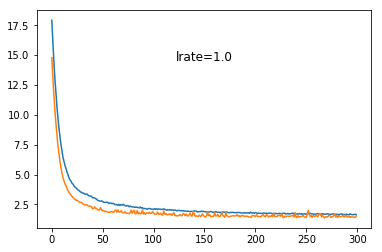

In [32]:
Y_predict = model.predict(X_test_scaled)
error_metrics(Y_test, Y_predict)
# plot learning curves
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.title('lrate='+str(lrate), pad=-50)

In [35]:
# create learning curves for different learning rates
learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4]
for i in range(len(learning_rates)):
    lrate = learning_rates[i]
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    # fit model and plot learning curves for a learning rate
    history, model = fit_model(lrate)
    
    Y_predict = model.predict(X_test_scaled)
    error_metrics(Y_test, Y_predict)
    # plot learning curves
    plt.plot(history.history['mse'], label='train')
    plt.plot(history.history['val_mse'], label='test')
    plt.title('lrate='+str(lrate), pad=-20)
plt.show()
    

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6016/6536 [==========================>...] - ETA: 0s - loss: 442.6919 - mse: 442.6897 - mae: 17.6943 - accuracy: 0.0000e+00 - mape: 625.8401
Epoch 00001: val_mape improved from inf to 994546.12500, saving model to Daily Experiments/Base/Manual All/Model_Loss_mse
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Loss_mse/assets
6536/6536 [==============================] - 3s 508us/sample - loss: 120711.0575 - mse: 120711.0469 - mae: 52.8300 - accuracy: 0.0000e+00 - mape: 1689.0447 - val_loss: 699110074.7469 - val_mse: 699110016.0000 - val_mae: 26440.6934 - val_accuracy: 0.0000e+00 - val_mape: 994546.1250
Epoch 2/300
5952/6536 [==========================>...] - ETA: 0s - loss: nan - mse: nan - mae: nan - accuracy: 0.0000e+00 - mape: nan                                                                                                  
Epoch 00002: val_mape did not improve from 994546.12500
6536/6536 [=====

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

<h4> Vary Momentum </h4>

In [51]:
# # fit a model and plot learning curve
# def fit_model(trainX, trainy, validX, validy, momentum):
#     # define model
#     model = Sequential()
#     model.add(Dense(50, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dense(1, activation='softmax'))
#       # compile model
#     opt = SGD(lr=0.01, momentum= momentum)
#     model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mse', 'mae'])
#     # fit model
#     history = model.fit(trainX, trainy, validation_data=(validX, validy), epochs=200, verbose=1, callbacks=callbacks)
    
#     y_predict = model.predict(X_test_scaled)
#     error_metrics(y_test, y_predict)
#     # plot learning curves
#     pyplot.plot(history.history['mse'], label='train')
#     pyplot.plot(history.history['val_mse'], label='test')
#     pyplot.title('momentum='+str(momentum), pad=-50)
    
def fit_model(momentum, first_neuron=64, 
              activation='softmax',
                 init='uniform',
                 dropout_rate = 0.4,
                 optimizer='Adam',
                 loss='mse'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=X_train_scaled.shape[1], kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for _ in range(1, 3):
        model.add(Dense(first_neuron, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    opt = tensorflow.keras.optimizers.SGD(lr=0.01, momentum= momentum)
    model.compile(optimizer=opt, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    output_path = "Daily Experiments/Base/Manual All/Model_Loss_" + str(loss)
    mc = ModelCheckpoint(output_path, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
    history = model.fit(X_train_scaled, Y_train, validation_data=(X_valid_scaled, Y_valid),callbacks=[es, mc], epochs=300, batch_size=64, verbose=1)
    return (history, model)

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6464/6536 [============================>.] - ETA: 0s - loss: 7.6140 - mse: 7.6114 - mae: 2.1056 - accuracy: 0.0000e+00 - mape: 54.2081
Epoch 00001: val_mape improved from inf to 55.73230, saving model to Daily Experiments/Base/Manual All/Model_Loss_mse
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Loss_mse/assets
6536/6536 [==============================] - 4s 576us/sample - loss: 7.5688 - mse: 7.5663 - mae: 2.0985 - accuracy: 0.0000e+00 - mape: 54.1932 - val_loss: 3.6581 - val_mse: 3.6555 - val_mae: 1.5191 - val_accuracy: 0.0000e+00 - val_mape: 55.7323
Epoch 2/300
6400/6536 [============================>.] - ETA: 0s - loss: 4.1569 - mse: 4.1543 - mae: 1.6158 - accuracy: 0.0000e+00 - mape: 57.7425
Epoch 00002: val_mape did not improve from 55.73230
6536/6536 [==============================] - 1s 104us/sample - loss: 4.1579 - mse: 4.1553 - mae: 1.6174 - accuracy: 0.0000e+00 - mape: 57.7100 - val_los

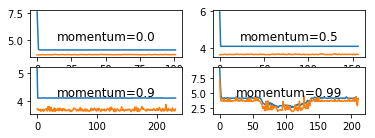

In [52]:
# create learning curves for different momentums
momentums = [0.0, 0.5, 0.9, 0.99]
for i in range(len(momentums)):
    momentum = momentums[i]
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    # fit model and plot learning curves for a momentum
    history, model = fit_model(momentum)
    
    Y_predict = model.predict(X_test_scaled)
    error_metrics(Y_test, Y_predict)
    # plot learning curves
    plt.plot(history.history['mse'], label='train')
    plt.plot(history.history['val_mse'], label='test')
    plt.title('momentum='+str(momentum), pad=-30)

plt.show()

#### Decay Rate

In [38]:
def fit_model(decay, first_neuron=64, 
              activation='softmax',
                 init='uniform',
                 dropout_rate = 0.4,
                 optimizer='Adam',
                 loss='mse'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=X_train_scaled.shape[1], kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for _ in range(1, 3):
        model.add(Dense(first_neuron, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    opt = tensorflow.keras.optimizers.SGD(lr=0.01, decay= decay)
    model.compile(optimizer=opt, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    output_path = "Daily Experiments/Base/Manual All/Model_Loss_" + str(loss)
    mc = ModelCheckpoint(output_path, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
    history = model.fit(X_train_scaled, Y_train, validation_data=(X_valid_scaled, Y_valid),callbacks=[es, mc], epochs=300, batch_size=64, verbose=1)
    return (history, model)

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6208/6536 [===========================>..] - ETA: 0s - loss: 11.7156 - mse: 11.7130 - mae: 2.7590 - accuracy: 0.0000e+00 - mape: 63.2658
Epoch 00001: val_mape improved from inf to 48.67974, saving model to Daily Experiments/Base/Manual All/Model_Loss_mse
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Loss_mse/assets
6536/6536 [==============================] - 3s 416us/sample - loss: 11.6622 - mse: 11.6596 - mae: 2.7458 - accuracy: 0.0000e+00 - mape: 62.7153 - val_loss: 7.8187 - val_mse: 7.8161 - val_mae: 2.1198 - val_accuracy: 0.0000e+00 - val_mape: 48.6797
Epoch 2/300
6080/6536 [==========================>...] - ETA: 0s - loss: 8.6965 - mse: 8.6939 - mae: 2.2544 - accuracy: 0.0000e+00 - mape: 49.3733
Epoch 00002: val_mape improved from 48.67974 to 45.11992, saving model to Daily Experiments/Base/Manual All/Model_Loss_mse
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Lo

NameError: name 'pyplot' is not defined

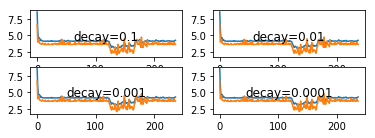

In [40]:
# create learning curves for different decay rates
decay_rates = [1E-1, 1E-2, 1E-3, 1E-4]
for i in range(len(decay_rates)):
    decay_rate = decay_rates[i]
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    # fit model and plot learning curves for a decay rate
    fit_model(decay_rate)
    plt.plot(history.history['mse'], label='train')
    plt.plot(history.history['val_mse'], label='test')
    plt.title('decay='+str(decay_rate), pad=-30)
    
# show learning curves
plt.show()

#### Drop Learning Rate on Plateau

In [53]:
# monitor the learning rate
class LearningRateMonitor(Callback): # start of training
    def on_train_begin(self, logs={}):
        self.lrates = list()
      # end of each training epoch
    
    def on_epoch_end(self, epoch, logs={}):
        # get and store the learning rate
        optimizer = self.model.optimizer
        lrate = float(backend.get_value(optimizer.lr))
        self.lrates.append(lrate)
        
    # fit a model and plot learning curve
    def fit_model(trainX, trainy, testX, testy, patience):
        # define model
        model = Sequential()
        model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(3, activation='softmax'))
        # compile model
        opt = SGD(lr=0.01)
        model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mse', 'mae'])
       # fit model
        rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience,
        min_delta=1E-7)
        lrm = LearningRateMonitor()
        history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200,
        verbose=0, callbacks=[rlrp, lrm])
        
        y_predict = model.predict(X_test_scaled)
        error_metrics(y_test, y_predict)
    
        return lrm.lrates, history.history['loss'], history.history['acc']
    
    # create line plots for a series
    def line_plots(patiences, series):
        for i in range(len(patiences)):
            pyplot.subplot(220 + (i+1))
            pyplot.plot(series[i])
            pyplot.title('patience='+str(patiences[i]), pad=-80)
        
        pyplot.show()
        # prepare dataset
        trainX, trainy, testX, testy = prepare_data()
        # create learning curves for different patiences
        patiences = [2, 5, 10, 15]
        
        lr_list, loss_list, acc_list, = list(), list(), list()
        
        for i in range(len(patiences)):
        # fit model and plot learning curves for a patience
            lr, loss, acc = fit_model(X_train_scaled, y_train, X_valid_scaled, y_valid,  patiences[i])
            
            lr_list.append(lr)
            loss_list.append(loss)
            acc_list.append(acc)
            # plot learning rates
            line_plots(patiences, lr_list)
            # plot loss
            line_plots(patiences, loss_list)
            # plot accuracy
            line_plots(patiences, acc_list)

Keras provides a number of different popular variations of stochastic gradient descent with adaptive learning rates, such as:
<ul>
    <li>Adaptive Gradient Algorithm (AdaGrad)</li>
<li>Root Mean Square Propagation (RMSprop)</li>
<li>Adaptive Moment Estimation (Adam)</li>
</ul>

In [6]:
# fit a model and plot learning curve
# def fit_model(trainX, trainy, validX, validy, optimizer):
#     # define model
#     model = Sequential()
#     model.add(Dense(50, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dense(1, activation='softmax'))
#       # compile model
#     model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', 'mse', 'mae'])
#     # fit model
#     history = model.fit(trainX, trainy, validation_data=(validX, validy), epochs=200, verbose=1, callbacks=callbacks)
    
#     y_predict = model.predict(X_test_scaled)
#     error_metrics(y_test, y_predict)
#     # plot learning curves
#     pyplot.plot(history.history['mse'], label='train')
#     pyplot.plot(history.history['val_mse'], label='test')
#     pyplot.title('optimizer='+optimizer, pad=-50)
    

def fit_model(first_neuron=64, 
              activation='softmax',
                 init='uniform',
                 dropout_rate = 0.4,
                 optimizer='Adam',
                 loss='mse'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=X_train_scaled.shape[1], kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for _ in range(1, 3):
        model.add(Dense(first_neuron, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    output_path = "Daily Experiments/Base/Manual All/Model_Loss_" + str(loss)
    mc = ModelCheckpoint(output_path, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
    history = model.fit(X_train_scaled, Y_train, validation_data=(X_valid_scaled, Y_valid),callbacks=[es, mc], epochs=300, batch_size=64, verbose=1)
    return (history, model)

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6208/6536 [===========================>..] - ETA: 0s - loss: 7.8623 - mse: 7.8598 - mae: 2.1405 - accuracy: 0.0000e+00 - mape: 54.2738
Epoch 00001: val_mape improved from inf to 55.43375, saving model to Daily Experiments/Base/Manual All/Model_Loss_mse
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/Model_Loss_mse/assets
6536/6536 [==============================] - 4s 557us/sample - loss: 7.6453 - mse: 7.6427 - mae: 2.1093 - accuracy: 0.0000e+00 - mape: 54.4988 - val_loss: 3.6655 - val_mse: 3.6630 - val_mae: 1.5185 - val_accuracy: 0.0000e+00 - val_mape: 55.4338
Epoch 2/300
5952/6536 [==========================>...] - ETA: 0s - loss: 4.1325 - mse: 4.1299 - mae: 1.6058 - accuracy: 0.0000e+00 - mape: 56.6062
Epoch 00002: val_mape did not improve from 55.43375
6536/6536 [==============================] - 1s 101us/sample - loss: 4.

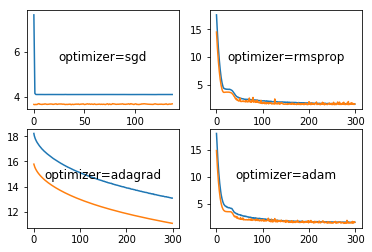

In [7]:
# create learning curves for different optimizers
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adam']
for i in range(len(optimizers)):
  # determine the plot number
    plot_no = 220 + (i+1)
    plt.subplot(plot_no)
# fit model and plot learning curves for an optimizer
    history, model = fit_model(optimizer=optimizers[i])
    Y_predict = model.predict(X_test_scaled)
    error_metrics(Y_test, Y_predict)
    # plot learning curves
    plt.plot(history.history['mse'], label='train')
    plt.plot(history.history['val_mse'], label='test')
    plt.title('optimizer='+optimizers[i], pad=-50)
# show learning curves
plt.show()

<h3> Chapter 6: Stabilize Learning with Data Scaling </h3>

Trying different input and output standardization and normalization techniques

In [7]:
X = df.drop([output_column, "Site Id"], axis = 1)
Y = df[output_column]
    
print(X.shape, Y.shape)
n_input = X.shape[1]
n_classes = 1
print("num of input:", n_input, "num of classes:", n_classes)

nb_columns = len(list(df.columns.values)) - 1


# prepare dataset with input and output scalers, can be none
def get_dataset(input_scaler, output_scaler):
    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
    # scale inputs
    if input_scaler is not None:
        # fit scaler
        input_scaler.fit(X_train)
            # transform training dataset
        X_train = input_scaler.transform(X_train)
            # transform test dataset
        X_test = input_scaler.transform(X_test)
    if output_scaler is not None:
        # reshape 1d arrays to 2d arrays
        y_train = np.array(y_train).reshape(len(y_train), 1)
        y_test = np.array(y_test).reshape(len(y_test), 1)
        # fit scaler on training dataset
        output_scaler.fit(y_train)
        # transform training dataset
        y_train = output_scaler.transform(y_train)
        # transform test dataset
        y_test = output_scaler.transform(y_test)

    return X_train, y_train, X_test, y_test

# fit and evaluate mse of model on test set
def evaluate_model(trainX, trainy, testX, testy):
    # define model
    model = Sequential()
    model.add(Dense(64, input_dim=trainX.shape[-1], activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='linear'))
    # compile model
    model.compile(loss='mean_squared_error', optimizer='Adam')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    output_path = "Daily Experiments/Base/Manual All/Model_Loss_mse"
    mc = ModelCheckpoint(output_path, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
    
    # fit model
    model.fit(trainX, trainy, epochs=100, callbacks=[es, mc], batch_size = 64, verbose=1)
    
    y_predict = model.predict(testX)
    error_metrics(testy, y_predict)
    
    # evaluate the model
    test_mse = model.evaluate(testX, testy, verbose=0)
    return test_mse

# def evaluate_model(first_neuron=64, 
#               activation='softmax',
#                  init='uniform',
#                  dropout_rate = 0.4,
#                  optimizer='Adam',
#                  loss='mse'):
#     # Create model
#     model = tensorflow.keras.Sequential()
#     model.add(Dense(first_neuron, input_dim=X_train_scaled.shape[1], kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate))
#     for _ in range(1, 3):
#         model.add(Dense(first_neuron, activation=activation))
#         model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation="linear"))
#     model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
#     output_path = "Daily Experiments/Base/Manual All/Model_Loss_" + str(loss)
#     mc = ModelCheckpoint(output_path, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
#     history = model.fit(X_train_scaled, Y_train, validation_data=(X_valid_scaled, Y_valid),callbacks=[es, mc], epochs=300, batch_size=64, verbose=1)
#     return (history, model)

# evaluate model multiple times with given input and output scalers
def repeated_evaluation(input_scaler, output_scaler, n_repeats=3):
    # get dataset
    trainX, trainy, testX, testy = get_dataset(input_scaler, output_scaler)

    # repeated evaluation of model
    results = list()
    for _ in range(n_repeats):
        test_mse = evaluate_model(trainX, trainy, testX, testy)
        print('>%.3f' % test_mse)
        results.append(test_mse)
    return results

# This can be further tuned to vary the range for MinMaxScaler and to use RobustScaler
# unscaled inputs
results_unscaled_inputs = repeated_evaluation(None, StandardScaler())
# normalized inputs
results_normalized_inputs = repeated_evaluation(MinMaxScaler(), StandardScaler())
# standardized inputs
results_standardized_inputs = repeated_evaluation(StandardScaler(), StandardScaler())
#only input normalized
results_minmax_inputs = repeated_evaluation(MinMaxScaler(), None)


(10911, 49) (10911,)
num of input: 49 num of classes: 1
Train on 8183 samples
Epoch 1/100
8183/8183 [==============================] - 1s 79us/sample - loss: 4063.7930
Epoch 2/100
3520/8183 [===========>..................] - ETA: 0s - loss: 24.8216

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mape available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8183/8183 [==============================] - 0s 43us/sample - loss: 24.5040
Epoch 3/100
8183/8183 [==============================] - 0s 43us/sample - loss: 22.0741
Epoch 4/100
8183/8183 [==============================] - 0s 41us/sample - loss: 19.9066
Epoch 5/100
8183/8183 [==============================] - 0s 41us/sample - loss: 17.9636
Epoch 6/100
8183/8183 [==============================] - 0s 41us/sample - loss: 16.2889
Epoch 7/100
8183/8183 [==============================] - 0s 42us/sample - loss: 14.8112
Epoch 8/100
8183/8183 [==============================] - 0s 42us/sample - loss: 13.4724
Epoch 9/100
8183/8183 [==============================] - 0s 43us/sample - loss: 12.1932
Epoch 10/100
8183/8183 [==============================] - 0s 42us/sample - loss: 11.0629
Epoch 11/100
8183/8183 [==============================] - 0s 42us/sample - loss: 9.9061
Epoch 12/100
8183/8183 [==============================] - 0s 44us/sample - loss: 8.9490
Epoch 13/100
8183/8183 [===================

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mape available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8183/8183 [==============================] - 0s 47us/sample - loss: 22.2035
Epoch 3/100
8183/8183 [==============================] - 0s 42us/sample - loss: 12.3581
Epoch 4/100
8183/8183 [==============================] - 0s 42us/sample - loss: 8.3948
Epoch 5/100
8183/8183 [==============================] - 0s 42us/sample - loss: 5.6763
Epoch 6/100
8183/8183 [==============================] - 0s 42us/sample - loss: 4.2720
Epoch 7/100
8183/8183 [==============================] - 0s 42us/sample - loss: 3.5473
Epoch 8/100
8183/8183 [==============================] - 0s 41us/sample - loss: 3.1181
Epoch 9/100
8183/8183 [==============================] - 0s 41us/sample - loss: 2.8731
Epoch 10/100
8183/8183 [==============================] - 0s 41us/sample - loss: 2.6135
Epoch 11/100
8183/8183 [==============================] - 0s 43us/sample - loss: 2.4854
Epoch 12/100
8183/8183 [==============================] - 0s 44us/sample - loss: 2.5685
Epoch 13/100
8183/8183 [==========================

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mape available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8183/8183 [==============================] - 0s 43us/sample - loss: 236.3391
Epoch 3/100
8183/8183 [==============================] - 0s 41us/sample - loss: 203.1255
Epoch 4/100
8183/8183 [==============================] - 0s 41us/sample - loss: 115.0329
Epoch 5/100
8183/8183 [==============================] - 0s 42us/sample - loss: 55.5867
Epoch 6/100
8183/8183 [==============================] - 0s 43us/sample - loss: 35.4001
Epoch 7/100
8183/8183 [==============================] - 0s 42us/sample - loss: 24.4697
Epoch 8/100
8183/8183 [==============================] - 0s 43us/sample - loss: 17.1364
Epoch 9/100
8183/8183 [==============================] - 0s 42us/sample - loss: 12.5077
Epoch 10/100
8183/8183 [==============================] - 0s 42us/sample - loss: 9.6511
Epoch 11/100
8183/8183 [==============================] - 0s 43us/sample - loss: 7.8328
Epoch 12/100
8183/8183 [==============================] - 0s 42us/sample - loss: 6.7346
Epoch 13/100
8183/8183 [=================

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mape available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8183/8183 [==============================] - 0s 41us/sample - loss: 0.5764
Epoch 3/100
8183/8183 [==============================] - 0s 44us/sample - loss: 0.5215
Epoch 4/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4893
Epoch 5/100
8183/8183 [==============================] - 0s 45us/sample - loss: 0.4657
Epoch 6/100
8183/8183 [==============================] - 0s 41us/sample - loss: 0.4591
Epoch 7/100
8183/8183 [==============================] - 0s 41us/sample - loss: 0.4371
Epoch 8/100
8183/8183 [==============================] - 0s 41us/sample - loss: 0.4313
Epoch 9/100
8183/8183 [==============================] - 0s 41us/sample - loss: 0.4231
Epoch 10/100
8183/8183 [==============================] - 0s 41us/sample - loss: 0.4136
Epoch 11/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4070
Epoch 12/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4006
Epoch 13/100
8183/8183 [============================

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mape available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8183/8183 [==============================] - 0s 42us/sample - loss: 0.5700
Epoch 3/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.5187
Epoch 4/100
8183/8183 [==============================] - 0s 42us/sample - loss: 0.4881
Epoch 5/100
8183/8183 [==============================] - 0s 44us/sample - loss: 0.4711
Epoch 6/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4438
Epoch 7/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4354
Epoch 8/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4202
Epoch 9/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4123
Epoch 10/100
8183/8183 [==============================] - 0s 44us/sample - loss: 0.4026
Epoch 11/100
8183/8183 [==============================] - 0s 42us/sample - loss: 0.3977
Epoch 12/100
8183/8183 [==============================] - 0s 41us/sample - loss: 0.3908
Epoch 13/100
8183/8183 [============================

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mape available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8183/8183 [==============================] - 0s 43us/sample - loss: 0.5698
Epoch 3/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.5254
Epoch 4/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4914
Epoch 5/100
8183/8183 [==============================] - 0s 45us/sample - loss: 0.4667
Epoch 6/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4436
Epoch 7/100
8183/8183 [==============================] - 0s 42us/sample - loss: 0.4343
Epoch 8/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4169
Epoch 9/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4121
Epoch 10/100
8183/8183 [==============================] - 0s 46us/sample - loss: 0.4045
Epoch 11/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3947
Epoch 12/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3890
Epoch 13/100
8183/8183 [============================

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mape available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8183/8183 [==============================] - 0s 42us/sample - loss: 0.5233
Epoch 3/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4581
Epoch 4/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4252
Epoch 5/100
8183/8183 [==============================] - 0s 44us/sample - loss: 0.3990
Epoch 6/100
8183/8183 [==============================] - 0s 44us/sample - loss: 0.3844
Epoch 7/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3697
Epoch 8/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3595
Epoch 9/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3494
Epoch 10/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3428
Epoch 11/100
8183/8183 [==============================] - 0s 42us/sample - loss: 0.3351
Epoch 12/100
8183/8183 [==============================] - 0s 41us/sample - loss: 0.3300
Epoch 13/100
8183/8183 [============================

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mape available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8183/8183 [==============================] - 0s 44us/sample - loss: 0.5075
Epoch 3/100
8183/8183 [==============================] - 0s 47us/sample - loss: 0.4412
Epoch 4/100
8183/8183 [==============================] - 0s 42us/sample - loss: 0.4087
Epoch 5/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3854
Epoch 6/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3685
Epoch 7/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3580
Epoch 8/100
8183/8183 [==============================] - 0s 45us/sample - loss: 0.3470
Epoch 9/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3411
Epoch 10/100
8183/8183 [==============================] - 0s 44us/sample - loss: 0.3316
Epoch 11/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3287
Epoch 12/100
8183/8183 [==============================] - 0s 44us/sample - loss: 0.3249
Epoch 13/100
8183/8183 [============================

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mape available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8183/8183 [==============================] - 0s 44us/sample - loss: 0.4926
Epoch 3/100
8183/8183 [==============================] - 0s 42us/sample - loss: 0.4365
Epoch 4/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.4063
Epoch 5/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3874
Epoch 6/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3726
Epoch 7/100
8183/8183 [==============================] - 0s 46us/sample - loss: 0.3598
Epoch 8/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3515
Epoch 9/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3414
Epoch 10/100
8183/8183 [==============================] - 0s 42us/sample - loss: 0.3369
Epoch 11/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3282
Epoch 12/100
8183/8183 [==============================] - 0s 43us/sample - loss: 0.3201
Epoch 13/100
8183/8183 [============================

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mape available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8183/8183 [==============================] - 0s 44us/sample - loss: 2.3771
Epoch 3/100
8183/8183 [==============================] - 0s 44us/sample - loss: 2.1451
Epoch 4/100
8183/8183 [==============================] - 0s 44us/sample - loss: 2.0180
Epoch 5/100
8183/8183 [==============================] - 0s 44us/sample - loss: 1.9217
Epoch 6/100
8183/8183 [==============================] - 0s 43us/sample - loss: 1.8537
Epoch 7/100
8183/8183 [==============================] - 0s 43us/sample - loss: 1.8305
Epoch 8/100
8183/8183 [==============================] - 0s 46us/sample - loss: 1.7511
Epoch 9/100
8183/8183 [==============================] - 0s 43us/sample - loss: 1.7258
Epoch 10/100
8183/8183 [==============================] - 0s 43us/sample - loss: 1.6909
Epoch 11/100
8183/8183 [==============================] - 0s 44us/sample - loss: 1.6662
Epoch 12/100
8183/8183 [==============================] - 0s 44us/sample - loss: 1.6490
Epoch 13/100
8183/8183 [============================

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mape available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8183/8183 [==============================] - 0s 47us/sample - loss: 2.5244
Epoch 3/100
8183/8183 [==============================] - 0s 43us/sample - loss: 2.2627
Epoch 4/100
8183/8183 [==============================] - 0s 43us/sample - loss: 2.1398
Epoch 5/100
8183/8183 [==============================] - 0s 42us/sample - loss: 2.0414
Epoch 6/100
8183/8183 [==============================] - 0s 43us/sample - loss: 1.9626
Epoch 7/100
8183/8183 [==============================] - 0s 43us/sample - loss: 1.9044
Epoch 8/100
8183/8183 [==============================] - 0s 44us/sample - loss: 1.8522
Epoch 9/100
8183/8183 [==============================] - 0s 44us/sample - loss: 1.8029
Epoch 10/100
8183/8183 [==============================] - 0s 43us/sample - loss: 1.7633
Epoch 11/100
8183/8183 [==============================] - 0s 43us/sample - loss: 1.7269
Epoch 12/100
8183/8183 [==============================] - 0s 47us/sample - loss: 1.6941
Epoch 13/100
8183/8183 [============================

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mape available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8183/8183 [==============================] - 0s 43us/sample - loss: 2.3945
Epoch 3/100
8183/8183 [==============================] - 0s 45us/sample - loss: 2.1682
Epoch 4/100
8183/8183 [==============================] - 0s 43us/sample - loss: 2.0497
Epoch 5/100
8183/8183 [==============================] - 0s 47us/sample - loss: 1.9589
Epoch 6/100
8183/8183 [==============================] - 0s 52us/sample - loss: 1.8883
Epoch 7/100
8183/8183 [==============================] - 0s 53us/sample - loss: 1.8253
Epoch 8/100
8183/8183 [==============================] - 0s 52us/sample - loss: 1.7837
Epoch 9/100
8183/8183 [==============================] - 0s 52us/sample - loss: 1.7351
Epoch 10/100
8183/8183 [==============================] - 0s 52us/sample - loss: 1.6904
Epoch 11/100
8183/8183 [==============================] - 0s 54us/sample - loss: 1.6709
Epoch 12/100
8183/8183 [==============================] - 0s 61us/sample - loss: 1.6399
Epoch 13/100
8183/8183 [============================

NameError: name 'mean' is not defined

Unscaled: 0.752 (0.230)
Normalized: 0.341 (0.006)
Standardized: 0.373 (0.003)
Input Normalized Only: 1.346 (0.033)


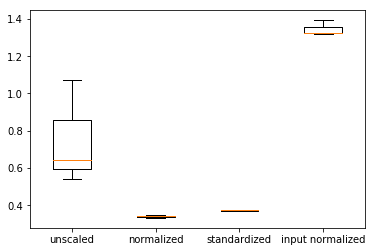

In [9]:
# summarize results
print('Unscaled: %.3f (%.3f)' % (np.mean(results_unscaled_inputs),np.std(results_unscaled_inputs)))
print('Normalized: %.3f (%.3f)' % (np.mean(results_normalized_inputs), np.std(results_normalized_inputs)))
print('Standardized: %.3f (%.3f)' % (np.mean(results_standardized_inputs), np.std(results_standardized_inputs)))
print('Input Normalized Only: %.3f (%.3f)' % (np.mean(results_minmax_inputs), np.std(results_minmax_inputs)))
# plot results
results = [results_unscaled_inputs, results_normalized_inputs, results_standardized_inputs, results_minmax_inputs]
labels = ['unscaled', 'normalized', 'standardized', 'input normalized']
plt.boxplot(results, labels=labels)
plt.show()

<h3> Chapter 7: Fix Vanishing Gradients with ReLU </h3>

In order to use stochastic gradient descent with backpropagation of errors to train deep neural networks, an activation function is needed that looks and acts like a linear function, but is, in fact, a nonlinear function allowing complex relationships in the data to be learned. The function must also provide more sensitivity to the activation sum input and avoid easy saturation

The solution is to use the rectified linear activation function, or ReL for short. A node or unit that implements this activation function is referred to as a rectified linear activation unit, or ReLU for short. Often, networks that use the rectifier function for the hidden layers are referred to as rectified networks

Positive values are returned regardless of their size, whereas negative values are snapped to the value 0.0

It avoids the problem of vanishing gradients, as the gradients remain proportional to the node activations, having this linearity, gradients flow well on the active paths of neurons (there is no gradient vanishing effect due to activation non-linearities of sigmoid or tanh units)


#### Multilayer Perceptron Model

Train: 19.904, Test: 20.404
The range for the output variable is: 4.553287389266667
r2score : -1.6232933487923797
adjusted r2score : -1.656304590597653
mae : 3.553289415824589
rmse : 4.517056332684902
mse : 20.403797912648773
re : 2040.3839262210877
mape : 67.08079488108221


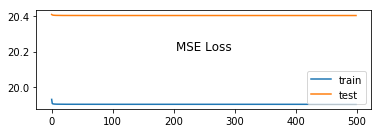

In [57]:
# scale input data to [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# define model
model = Sequential()
init = RandomUniform(minval=0, maxval=1)
model.add(Dense(5, input_dim=X_train_scaled.shape[-1], activation='tanh', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init))
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))
# fit model
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=500, verbose=0)

# evaluate the model
train_loss = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))

y_predict = model.predict(X_test_scaled)
error_metrics(y_test, y_predict)
    
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('MSE Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### Deeper MLP Model

In [58]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = Y[:n_train], Y[n_train:]
# define model
init = RandomUniform(minval=0, maxval=1)
model = Sequential()
model.add(Dense(5, input_dim=2, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init))
# compile model
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

# evaluate the model
train_loss = model.evaluate(trainX, trainy, verbose=0)
test_loss = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))

y_predict = model.predict(testX)
error_metrics(testy, y_predict)

# plot loss learning curves
pyplot.subplot(211)
pyplot.title('MSE Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

ValueError: Error when checking input: expected dense_179_input to have shape (2,) but got array with shape (30,)

#### Deeper MLP Model with ReLU

In [59]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = Y[:n_train], Y[n_train:]
# define model
model = Sequential()
model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

# evaluate the model
train_loss = model.evaluate(trainX, trainy, verbose=0)
test_loss = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))

y_predict = model.predict(testX)
error_metrics(testy, y_predict)

# plot loss learning curves
pyplot.subplot(211)
pyplot.title('MSE Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

ValueError: Error when checking input: expected dense_185_input to have shape (2,) but got array with shape (30,)

### Chapter 8: Fix Exploding Gradients with Gradient Clipping

Large updates to weights during training can cause a numerical overflow or underflow often referred to as exploding gradients

Exploding Gradients could occur as such:
<ul>
    <li>Poor choice of learning rate that results in large weight updates</li>
    <li> Poor choice of data preparation, allowing large differences in the target variable</li>
    <li>Poor choice of loss function, allowing the calculation of large error values</li>
</ul>

A common and relatively easy solution to the exploding gradients problem is to change the derivative of the error before propagating it backward through the network and using it to update the weights

Two approaches include rescaling the gradients given a chosen vector norm and clipping gradient values that exceed a preferred range. Together, these methods are referred to as gradient clipping

Solutions are:

<ul>
    <li>Gradient Scaling: It involves normalizing the error gradient vector such that vector norm (magnitude) equals a defined value, such as 1.0</li>
    <li>Gradient Clipping: It involves forcing the gradient values (element-wise) to a specific minimum or maximum value if the gradient exceeded an expected range</li>
</ul>

#### Gradient Scaling
It involves changing the derivatives of the loss function to have a given vector norm when the L2 vector norm (sum of the squared values) of the gradient vector exceeds a threshold value

In [60]:
# configure sgd with gradient norm clipping
opt = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)

#### Gradient Value Clipping
It involves clipping the derivatives of the loss function to have a given value if a gradient value is less than a negative threshold or more than the positive threshold

In [61]:
# configure sgd with gradient value clipping
opt = SGD(lr=0.01, momentum=0.9, clipvalue=0.5)

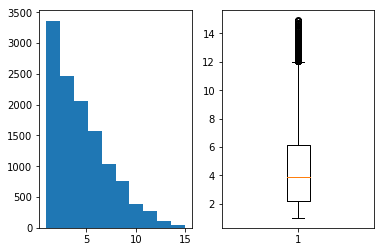

In [62]:
# histogram of target variable
pyplot.subplot(121)
pyplot.hist(Y)
# boxplot of target variable
pyplot.subplot(122)
pyplot.boxplot(Y)
pyplot.show()

#### MLP with Exploding Gradients
No scaling is done

Train: 7.822, Test: 7.814
The range for the output variable is: 4.553287389266667
r2score : -0.004622331206026065
adjusted r2score : -0.017264390743014557
mae : 2.301967554209445
rmse : 2.795332613294741
mse : 7.813884418949207
re : 164.74917287593678
mape : 80.93236267977191


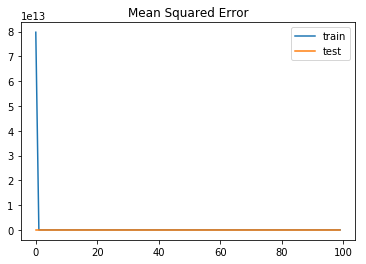

In [63]:
# define model
model = Sequential()
model.add(Dense(25, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
# compile model
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)

# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

y_predict = model.predict(X_test)
error_metrics(y_test, y_predict)

# plot loss during training
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### MLP With Gradient Norm Scaling

Train: 4.294, Test: 4.183
The range for the output variable is: 4.553287389266667
r2score : 0.46221303214205367
adjusted r2score : 0.4554455786874655
mae : 1.5756178165419816
rmse : 2.0452067366343316
mse : 4.182870595574452
re : 87.9185843254628
mape : 51.90046972227985


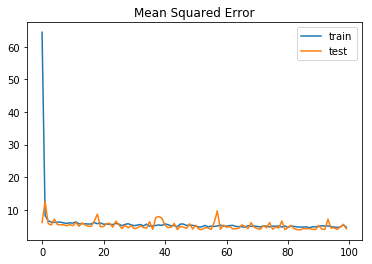

In [64]:
# define model
model = Sequential()
model.add(Dense(25, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
# compile model
optimization = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=optimization)
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)

# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

y_predict = model.predict(X_test)
error_metrics(y_test, y_predict)

# plot loss during training
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### MLP With Gradient Value Clipping

Train: 7.798, Test: 7.797
The range for the output variable is: 4.553287389266667
r2score : -0.002503154951533082
adjusted r2score : -0.015118547002097804
mae : 2.291544808182533
rmse : 2.792382783508927
mse : 7.797401609637063
re : 166.15597226022126
mape : 79.85810215710394


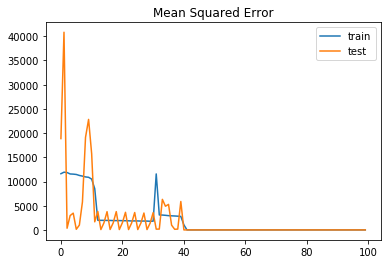

In [65]:
# define model
model = Sequential()
model.add(Dense(25, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
# compile model
optimizer = SGD(lr=0.01, momentum=0.9, clipvalue=5.0)
model.compile(loss='mean_squared_error', optimizer=optimizer)
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)

# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

y_predict = model.predict(X_test)
error_metrics(y_test, y_predict)

# plot loss during training
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Chapter 9: Accelerate Learning with Batch Normalization

One possible reason for a difficulty is the distribution of the inputs to layers deep in the network may change after each minibatch when the weights are updated. This can cause the learning algorithm to forever chase a moving target. This change in the distribution of inputs to layers in the network is referred to by the technical name internal covariate shift

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each minibatch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks. In this tutorial, you will discover the batch normalization method used to accelerate the training of deep learning neural networks

Train: 19.904, Test: 20.404
The range for the output variable is: 4.553287389266667
r2score : -1.623292978338469
adjusted r2score : -1.65630421548199
mae : 3.553288976897466
rmse : 4.5170560137420654
mse : 20.40379503128336
re : 2040.3827867681987
mape : 67.08077464301591


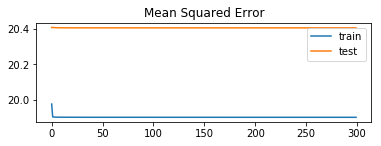

In [66]:
loss=# define model
model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
optimizer = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=optimizer)
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, verbose=0)

# evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))

y_predict = model.predict(X_test)
error_metrics(y_test, y_predict)

# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Chapter 10: Deeper Models with Greedy Layer-Wise Pretraining

 As the number of hidden layers is increased, the amount of error information propagated back to earlier layers is dramatically reduced. This means that weights in hidden layers close to the output layer are updated normally, whereas weights in hidden layers close to the input layer are updated minimally or not at all. Generally, this problem prevented the training of very deep neural networks and was referred to as the vanishing gradient problem. An important milestone in the resurgence of neural networks that initially allowed the development of deeper neural network models was the technique of greedy layer-wise pretraining, often simply referred to as pretraining
  
There are two main approaches to pretraining:
<ul>
    <li>Supervised greedy layer-wise pretraining</li>
    <li>Unsupervised greedy layer-wise pretraining</li>
</ul>

In [13]:
# define and fit the base model
def get_base_model(trainX, trainy):
    # define model
    model = Sequential()
    model.add(Dense(10, input_dim=trainX.shape[1], activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='linear'))
    # compile model
#     optimizer = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # fit model
    model.fit(trainX, trainy, epochs=100, verbose=0)
    return model

# evaluate a fit model
def evaluate_model(model, trainX, testX, trainy, testy):
    train_loss = model.evaluate(trainX, trainy, verbose=0)
    test_loss = model.evaluate(testX, testy, verbose=0)
    return train_loss, test_loss
    
    
# add one new layer and re-train only the new layer
def add_layer(model, trainX, trainy):
    # remember the current output layer
    output_layer = model.layers[-1]
    # remove the output layer 
    model.pop()
    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False

    # add a new hidden layer
    model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
    # re-add the output layer
    model.add(output_layer)
    # fit model
    model.fit(trainX, trainy, epochs=100, verbose=0)
    
    
# get the base model
X = df.drop([output_column, "Site Id"], axis = 1)
Y = df[output_column]
    
print(X.shape, Y.shape)
n_input = X.shape[1]
n_classes = 1
print("num of input:", n_input, "num of classes:", n_classes)

nb_columns = len(list(df.columns.values)) - 1

trainX, testX, trainy, testy = train_test_split(X, Y, random_state=42)
    
model = get_base_model(trainX, trainy)
# evaluate the base model
scores = dict()
train_loss, test_loss = evaluate_model(model, trainX, testX, trainy, testy)
print('> layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_loss, test_loss))

y_predict = model.predict(testX)
error_metrics(testy, y_predict)

scores[len(model.layers)] = (train_loss, test_loss)

# add layers and evaluate the updated model
n_layers = 10
for i in range(n_layers):
    # add layer
    add_layer(model, trainX, trainy)
      # evaluate model
    train_loss, test_loss = evaluate_model(model, trainX, testX, trainy, testy)
    print('> layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_loss, test_loss))
    # store scores for plotting
    scores[len(model.layers)] = (train_loss, test_loss)

(10911, 49) (10911,)
num of input: 49 num of classes: 1
> layers=2, train=2.222, test=2.333
Average target is: LE_bowen_corr(mm)    3.826096
dtype: float64
The range for the output variable is: 3.74367600959033
r2score : 0.42830501236715657
adjusted r2score : 0.41762710822758164
mae : 1.177534290404201
rmse : 1.5274257764292698
mse : 2.333029502500558
re : 55.04863852488639
mape : 79.48049837741968


ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: target=5851     2.459278
10852    1.527175
5890     3.812836
8284     3.707261
2004     1.377445
           ...   
6992     3.972332
6385     5.600568
6586     5.096701
1088     2.144571
9243     2.732306
Name: LE_bowen_corr(mm), Length: 8183, dtype: float64